In [1]:
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from abc import ABC, abstractmethod
from scipy.spatial.distance import cosine
from typing import List, Callable
from sentence_transformers import SentenceTransformer, util
from functools import reduce
from collections import Counter
from tqdm.notebook import tqdm
from pydantic import BaseModel, Field
from typing import List
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sqlalchemy
import time

nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_colwidth', None)

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

/home/demidov/anaconda3/lib/python3.8/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/demidov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/demidov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class RetrievedDoc(BaseModel):
    index: int
    company: str
    industry: str
    description: str
    title: str
    tag: str
    year: int
    link: str
    vector: str
    cos_sim_score: float
    
    @classmethod
    def from_list(cls, tpl):
        return cls(**{k: v for k, v in zip(cls.__fields__.keys(), tpl)})
    
class ExperimentResult(BaseModel):
    id: int
    agg_cols: List[str]
    output_col: str
    transform_list: List[str]
    model_name: str
    k: int = Field(default=5)
    mean_precison_at_k: float
    mean_top_accuracy_k: float
    

class Config:
    user = os.getenv('DB_USER')
    password = os.getenv('DB_PASSWORD')
    host = os.getenv('DB_HOST')
    port = os.getenv('DB_PORT')
    db_name = os.getenv('DB_NAME')
    
engine = create_engine(
    f'postgresql+psycopg2://{Config.user}:{Config.password}@{Config.host}:{Config.port}/{Config.db_name}', 
    pool_pre_ping=True,
    pool_recycle=1000,
    connect_args={
            "keepalives": 4,
            "keepalives_idle": 30,
            "keepalives_interval": 10,
            "keepalives_count": 5,
            "connect_timeout": 30
        }
    )

def db_execute(conn, query, params=None):
    try:
        result = conn.execute(query, params)
    except sqlalchemy.exc.OperationalError:
        time.sleep(10)  
        conn = engine.connect()
        result = conn.execute(query, params)
    return result

/home/demidov/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
df = pd.read_csv("evidently_table.csv")

In [4]:
df.head()

,Company,Industry,Short Description (< 5 words),Title,Tag,Year,Link
0,Stripe,Fintech and banking,Prevent fraudelent transactions,How we built it: Stripe Radar,fraud detection,2023,https://stripe.com/blog/how-we-built-it-stripe-radar
1,Walmart,E-commerce and retail,Recommend complementary items,Personalized ‘Complete the Look’ model,"recommender system,product feature,CV",2023,https://medium.com/walmartglobaltech/personalized-complete-the-look-model-ea093aba0b73
2,Uber,Delivery and mobility,Forecast demand for airport rides,Demand and ETR Forecasting at Airports,demand forecasting,2023,https://www.uber.com/en-GB/blog/demand-and-etr-forecasting-at-airports/
3,Pinterest,Social platforms,Prevent advertiser churn,An ML based approach to proactive advertiser churn prevention,churn prediction,2023,https://medium.com/pinterest-engineering/an-ml-based-approach-to-proactive-advertiser-churn-prevention-3a7c0c335016
4,Stitch Fix,E-commerce and retail,Generate ad headlines,A New Era of Creativity: Expert-in-the-loop Generative AI at Stitch Fix,"product feature,NLP,generative AI",2023,https://multithreaded.stitchfix.com/blog/2023/03/06/expert-in-the-loop-generative-ai-at-stitch-fix/


<Axes: title={'center': 'Text length by words'}, ylabel='Count'>

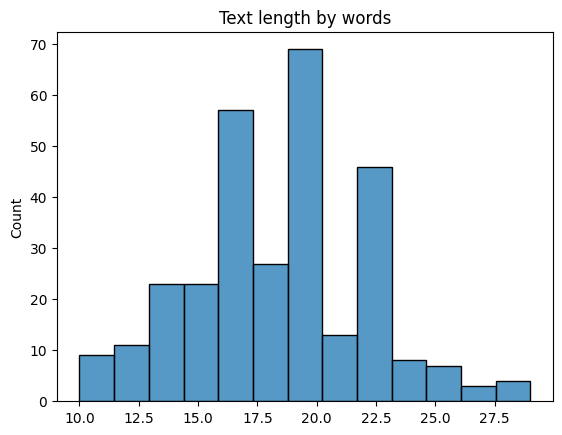

In [5]:
full_texts = df['Company'] + " " + df['Industry'] + " " + df['Short Description (< 5 words)'] + \
    " " + df['Title'] + " " + df['Tag']
plt.title("Text length by words")
sns.histplot(full_texts.apply(lambda s: len(s.split(" "))))

In [6]:
all_tags = reduce(lambda a,b: a + b, [elem.split(",") for elem in df['Tag'].values.tolist()])

all_tags_freq = Counter(all_tags)
all_tags_freq = {k: v for k, v in sorted(all_tags_freq.items(), key=lambda item: item[1], reverse=True)}

all_tags = list(set(all_tags))
all_tags

['NLP',
 'item classificatiion',
 'content personalization',
 'churn prediction',
 'pricing',
 'CV',
 'recommender system',
 'product feature',
 'customer support',
 'item classification',
 'chatbot',
 'ops',
 'predictive maintenance',
 'ad ranking / targeting',
 'fraud detection',
 'causality',
 'ETA prediction',
 'lead scoring',
 'propensity to buy',
 'spam / content moderation',
 'voice interface',
 'spam/content moderation',
 'search',
 'generative AI',
 'demand forecasting']

In [7]:
all_tags_freq

{'recommender system': 59,
 'product feature': 58,
 'ops': 42,
 'search': 37,
 'NLP': 36,
 'generative AI': 23,
 'fraud detection': 21,
 'demand forecasting': 21,
 'content personalization': 19,
 'ETA prediction': 18,
 'CV': 17,
 'item classification': 16,
 'ad ranking / targeting': 15,
 'causality': 10,
 'spam / content moderation': 8,
 'propensity to buy': 8,
 'pricing': 5,
 'customer support': 5,
 'lead scoring': 4,
 'voice interface': 4,
 'churn prediction': 3,
 'predictive maintenance': 2,
 'item classificatiion': 1,
 'spam/content moderation': 1,
 'chatbot': 1}

In [8]:
computer_vision_queries = [
    'Computer vision algorithm design',
    'Best practices for computer vision system design',
    'Machine learning system design for computer vision',
    'Computer vision model architecture design',
    'Optimizing performance of computer vision systems',
    'Implementing deep learning for computer vision',
    'Computer vision applications and system design',
    'Scalability of computer vision systems',
    'Computer vision system architecture',
    'Building a robust computer vision system'
]

nlp_queries = [
    "ML system design for sentiment analysis using NLP",
    "Recommendations for ML system design for language translation using NLP",
    "Best practices for ML system design for named entity recognition using NLP",
    "ML system architecture for text classification using NLP",
    "Case studies on ML system design for speech recognition using NLP",
    "Tips for ML system design for topic modeling using NLP",
    "Comparison of different ML system designs for text summarization using NLP",
    "Challenges in ML system design for sentiment analysis using NLP",
    "ML system design for text generation using NLP techniques",
    "ML system design for intent classification using NLP"
]

recommendation_queries = [
    "Recommendation system design for e-commerce platforms",
    "ML system design for personalized movie recommendations",
    "Building a recommendation system for online news articles",
    "Designing a collaborative filtering system for music suggestions",
    "Creating a recommendation engine for online shopping websites",
    "Machine learning model architecture for book recommendations",
    "Building a content-based recommendation system for social media platforms",
    "Designing a recommendation system for online courses",
    "ML system design for restaurant recommendations",
    "Building a hybrid recommendation system for video streaming platforms",
    "Creating a collaborative filtering system for product recommendations",
    "Machine learning model architecture for hotel recommendations",
    "Designing a content-based recommendation system for cooking recipes",
    "ML system design for job recommendations",
    "Building a recommendation engine for fashion and clothing websites",
    "Creating a collaborative filtering system for podcast suggestions",
    "Designing a recommendation system for travel destinations",
    "Machine learning model architecture for workout and fitness recommendations",
]

fraud_detection_queries = [
    "ML system design for fraud detection",
    "Fraud detection machine learning system architecture",
    "Designing ML system for fraud detection",
    "Fraud detection AI system design",
    "Machine learning approach for fraud detection",
    "ML model design for fraud detection",
    "Building a fraud detection ML system",
    "Fraud detection using machine learning methods",
    "Architecting a fraud detection model with ML",
    "ML system design for online fraud detection",
    "Building a fraud detection system with machine learning",
    "Designing a machine learning model for fraud detection",
    "Fraud detection with ML system implementation",
    "ML system design for financial fraud detection",
    "Machine learning system for detecting fraud",
    "Building an ML-based fraud detection system",
    "Fraud detection ML model design process",
    "Designing a machine learning approach for fraud detection",
    "Implementing machine learning for fraud detection system",
    "Fraud detection system architecture using ML"
    ]

eta_prediction_queries = [
    "ETA prediction machine learning models",
    "Machine learning system design for ETA prediction",
    "ML algorithms for ETA prediction",
    "ETA prediction system architecture",
    "ML system components for ETA prediction",
    "ETA prediction model pipeline design",
    "Machine learning approaches for ETA prediction",
    "ETA prediction system optimization techniques",
    "ML model training strategies for ETA prediction",
    "Customer journey ETA prediction models",
    "Real-time ETA prediction using machine learning",
    "ETA prediction accuracy improvement techniques",
    "Feature engineering for ETA prediction ML models",
    "ETA prediction model evaluation methods",
    "ML model deployment strategies for ETA prediction",
    "Scalable ML system design for ETA prediction",
    "ETA prediction model interpretability techniques",
    "Time series forecasting for ETA prediction",
    "ML model selection criteria for ETA prediction",
    "ETA prediction model performance monitoring methods"
]

ranking_queries = [
    "ML system design for ranking algorithms",
    "Best practices for designing ML systems for ranking",
    "How to implement ranking models in ML systems",
    "Optimizing ML models for ranking tasks",
    "ML architecture for ranking functionality",
    "Scalable ML system design for ranking",
    "Efficiently handling large datasets for ML ranking systems",
    "Real-time ranking systems using ML",
    "ML techniques for improving ranking accuracy",
    "Building personalized ranking systems using ML",
    "Deep learning models for ranking in ML systems",
    "ML system design for search result ranking",
    "Designing recommendation systems with ranking algorithms",
    "Implementing collaborative filtering for ranking in ML systems",
    "Ranking evaluation metrics in ML system design",
    "Deploying ML ranking systems in production",
    "Handling bias and fairness in ranking systems",
    "Optimizing computational resources for ranking in ML systems",
    "ML system design for learning-to-rank algorithms",
    "Improving user engagement through ranking in ML systems"
]

spam_and_content_moderation_queries = ['Machine learning systems for spam detection',
 'Content moderation using machine learning',
 'ML system design for identifying spam',
 'Spam detection algorithms in content moderation',
 'Implementing machine learning for content moderation',
 'Algorithms for spam filtering in ML systems',
 'Creating a model for detecting spam in content',
 'Machine learning approach to content moderation',
 'Designing ML systems for spam prevention',
 'Using AI for content moderation and spam detection',
 'Best practices for building ML systems for spam filtering',
 'Incorporating machine learning in content moderation strategies',
 'Developing a machine learning solution for spam identification',
 'Machine learning techniques for content moderation',
 'Building a robust spam detection model using ML',
 'Efficient ML system design for content moderation',
 'Advanced algorithms for spam filtering in ML systems',
 'Implementing machine learning in content moderation platforms',
 'Creating a scalable model for spam detection with ML',
 'ML system design for real-time spam prevention'
 ]

generative_ai_queries = [
    "Generative AI system design for image generation",
    "ML model for generative AI in natural language processing",
    "Implementing generative AI for music composition",
    "Advancements in generative AI technology for video synthesis",
    "Applications of generative AI in creative content generation",
    "How to build a generative AI system for text generation",
    "Generative AI algorithms for deep learning in image recognition",
    "Using generative AI for creating realistic synthetic data",
    "Research on generative AI for healthcare applications",
    "Exploring generative AI for product design and prototyping",
    "Generative AI techniques for style transfer in images",
    "Best practices for training generative AI models",
    "Implementing reinforcement learning in generative AI systems",
    "Generative AI applications in virtual reality and augmented reality",
    "Building a generative AI pipeline for generating realistic faces",
    "Understanding the ethical implications of generative AI",
    "Generative AI approaches for autonomous vehicle simulation",
    "Using generative AI for anomaly detection in cybersecurity",
    "Generative AI models for predicting future trends in data analysis",
    "Challenges in deploying generative AI systems in production environments"   
]

In [9]:
topic_dataset = {
    'recommender system': recommendation_queries,
    'NLP': nlp_queries,
    'CV': computer_vision_queries,
    'fraud detection': fraud_detection_queries,
    'ETA prediction': eta_prediction_queries,
    'ad ranking / targeting': ranking_queries,
    'spam / content moderation': spam_and_content_moderation_queries,
    'generative AI': generative_ai_queries
}

In [23]:
df_test = pd.DataFrame()
for topic_name, queries in topic_dataset.items():
    df_ = pd.DataFrame(data={
        'query': queries,
        'topic': [topic_name] * len(queries)
    })
    df_test = pd.concat([df_test, df_])

df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.shape

(138, 2)

In [11]:
df_test

,query,topic
0,Creating a scalable model for spam detection with ML,spam / content moderation
1,Designing recommendation systems with ranking algorithms,ad ranking / targeting
2,ML model for generative AI in natural language processing,generative AI
3,Best practices for building ML systems for spam filtering,spam / content moderation
4,Best practices for training generative AI models,generative AI
...,...,...
133,ML system design for ranking algorithms,ad ranking / targeting
134,Designing ML systems for spam prevention,spam / content moderation
135,Machine learning approach to content moderation,spam / content moderation
136,Generative AI techniques for style transfer in images,generative AI


In [12]:
class AbstractRepository(ABC):
    @abstractmethod
    def add(self, batch):
        raise NotImplementedError
    
    @abstractmethod
    def find(self, input, k):
        raise NotImplementedError
    
class PostgresRepository(AbstractRepository):
    def __init__(self, 
                 connection,
                ) -> None:
        self.connection = connection


    def add(self, df: pd.DataFrame):
        
        embedding_dim = len(df['embedding'].values[0])
        
        drop_table_query = 'DROP TABLE if exists public.items;'
        create_table_query = f'''CREATE TABLE public.items (index bigserial PRIMARY KEY,
                                                    company text,
                                                    industry text,
                                                    description text,
                                                    title text,
                                                    tag text,
                                                    year int,
                                                    link text,
                                                    embedding vector({embedding_dim}))'''
        
        db_execute(self.connection, drop_table_query)
        db_execute(self.connection, create_table_query)
    
        for company, industry, description, title, tag, year, link, _, embedding in df.values:
            insert_query = 'INSERT INTO public.items (company, industry, description, title, tag, year, link, embedding) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)'
            params = (company, industry, description, title, tag, year, link, [float(elem) for elem in embedding])
            db_execute(self.connection, insert_query, params)
        
    def find(self, query_embedding, limit: int = 5):
        query_embedding = [float(element) for element in query_embedding]
        select_query = f"SELECT *, 1 - (embedding <=> '{query_embedding}') AS cosine_similarity FROM public.items ORDER BY cosine_similarity desc LIMIT {limit}"
        neighbours = db_execute(self.connection, select_query)
        return neighbours

In [13]:
class Preprocessor:
    @staticmethod
    def lower(text: str) -> str:
        return text.lower()

    @staticmethod
    def tokenize(text: str) -> List[str]:
        return word_tokenize(text)
    
    @staticmethod
    def remove_stop_words(text: str, language='english') -> List[str]:
        stop_words = set(stopwords.words(language))
        filtered_words = [word for word in text if word not in stop_words]
        return filtered_words
    
    @staticmethod
    def remove_punctuation(text: str) -> List[str]:
        punctuation = set(string.punctuation)
        filtered_words = [word for word in text if word not in punctuation]
        return filtered_words
    
    @staticmethod
    def combine_cols(df: pd.DataFrame, columns: List[str], output_col: str, sep=' ') -> pd.DataFrame:
        df[output_col] = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        return df
    
transformations = {
    'lower': Preprocessor.lower,
    'tokenize': Preprocessor.tokenize,
    'remove_stop_words': Preprocessor.remove_stop_words,
    'remove_punctuation': Preprocessor.remove_punctuation
}

In [14]:
class AbstractTransformer(ABC):
    @abstractmethod
    def transform(self):
        raise NotImplemented
    
class TfIdfTransformer(AbstractTransformer):
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        
    def fit_transform(self, texts):
        return self.vectorizer.fit_transform(texts)
    
    def transform(self, text: str) -> np.ndarray:
        text_emb = self.vectorizer.transform(np.array([text]))
        return text_emb.toarray()[0]
        
class EmbeddingTransformer(AbstractTransformer):
    def __init__(self, model_name: str, trust_remote_code=True):
        self.model = SentenceTransformer(model_name, trust_remote_code=trust_remote_code)

    def transform(self, text: str, convert_to_tensor=False) -> np.ndarray:
        return self.model.encode(text, convert_to_tensor=convert_to_tensor)
    
    @property
    def model_output_dim(self):
        return self.model.get_sentence_embedding_dimension()
    

In [15]:
def recall_at_k(labels: List[int], scores: List[float], k=5) -> float:
    inputs = list(zip(scores, labels))
    inputs = list(sorted(inputs, key=lambda elem: elem[0], reverse=True))
    count_found_relevant_docs = 0
    for i in range(k):
        count_found_relevant_docs += inputs[i][1]
    return count_found_relevant_docs / (sum(labels) + 1e-16)


def precision_at_k(tag: List[str], predicted_tags: List[str], k=5) -> float:
    score = 0
    
    predicted_tags = predicted_tags[:k]
    
    for predicted_tag in predicted_tags:
        if tag[0] in predicted_tag:
            score += 1
            
    return score / min(len(predicted_tags), k)
            
def mean_precision_at_k(total_tags: List[List[str]], total_predicted_tags: List[List[str]], k=5) -> float:
    total_score = 0
    N = len(total_tags)
    
    for tag, predicted_tags in zip(total_tags, total_predicted_tags):
        score = precision_at_k(tag, predicted_tags, k)
        total_score += score
    
    return total_score / N

def top_accuracy_k(tag: List[str], predicted_tags: List[str], k=5) -> float:
    for predicted_tag in predicted_tags:
        if tag[0] in predicted_tag:
            return 1
    
    return 0

def mean_top_accuracy_k(total_tags: List[List[str]], total_predicted_tags: List[List[str]], k=5) -> float:
    total_score = 0
    N = len(total_tags)
    
    for tag, predicted_tags in zip(total_tags, total_predicted_tags):
        score = top_accuracy_k(tag, predicted_tags, k)
        total_score += score
    
    return total_score / N

In [16]:
exp1 = {
    'agg_cols': ['Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 1,
    'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
}

exp2 = {
    'agg_cols': ['Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 2,
    'model_name': 'msmarco-distilbert-base-v4',
}

exp3 = {
    'agg_cols': ['Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 3,
    'model_name': 'sentence-transformers/msmarco-MiniLM-L-12-v3',
}

exp4 = {
    'agg_cols': ['Company', 'Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 4,
    'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
}

exp5 = {
    'agg_cols': ['Company', 'Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 5,
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
}

exp6 = {
    'agg_cols': ['Company', 'Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 6,
    'model_name': 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1',
}

exp7 = {
    'agg_cols': ['Company', 'Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 7,
    'model_name': 'Alibaba-NLP/gte-large-en-v1.5',
}

exp8 = {
    'agg_cols': ['Company', 'Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 8,
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
}

exp9 = {
    'agg_cols': ['Company', 'Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 9,
    'model_name': 'salsabiilashifa11/sbert-paper',
}

exp10 = {
    'agg_cols': ['Company', 'Short Description (< 5 words)', 'Title', 'Tag'],
    'output_col': 'Combined_text',
    'transform_list': [
        'lower', 'tokenize', 'remove_punctuation', 'remove_stop_words',
                      ],
    'id': 10,
    'model_name': 'ArtifactAI/arxiv-distilroberta-base-GenQ',
}

experiments = [
    exp1,
    exp2,   
    exp3,
    exp4,
    exp5,
    exp6,
    exp7,
    exp8,
    exp9,
    exp10,
]

In [17]:
class Experiment:
    def __init__(self, 
                 df: pd.DataFrame, 
                 transformer,
                 storage):
        self.df = df
        self.transformer = transformer
        self.storage = storage

    def preprocess(self, experiment):
        df = Preprocessor.combine_cols(self.df, experiment['agg_cols'], output_col=experiment['output_col'])
        for transform in experiment['transform_list']:
            func = transformations[transform]
            df[experiment['output_col']] = df[experiment['output_col']].apply(func)
        return df
        
    def calculate_embeddings(self, experiment, df):
        embeddings = self.transformer.transform(
            df[experiment['output_col']].apply(lambda s: " ".join(s))
        )
        return embeddings

    def store_embeddings(self, df, vectors):
        df['embedding'] = list(vectors)
        self.storage.add(df)

    def retrieve_topk(self, query_embedding, k=5):
        top_k = self.storage.find(query_embedding, limit=k)
        return top_k
    
    def calculate_and_store_embeddings(self, experiment):
        df = self.preprocess(experiment)
        embeddings = self.calculate_embeddings(experiment, df)
        self.store_embeddings(df, embeddings)

    def calculate_metrics(self, df_test, k=5):
        predicted_tags = []
        true_tags = []
        for query, tag in df_test.values:
            query_emb = self.transformer.transform(query)
            top_neighbors = self.retrieve_topk(query_emb, k=k)
            top_neighbors = [RetrievedDoc.from_list(neighbor) for neighbor in top_neighbors]
            top_tags = [top.tag for top in top_neighbors]
            true_tags.append([tag])
            predicted_tags.append(top_tags)
        
        mean_precision_at_k_score = mean_precision_at_k(true_tags, predicted_tags, k) 
        mean_top_accuracy_at_k_score = mean_top_accuracy_k(true_tags, predicted_tags, k)
        
        return mean_precision_at_k_score, mean_top_accuracy_at_k_score

In [18]:
experiment_results = []

with engine.connect() as conn:
    for exp in tqdm(experiments):
        experiment = Experiment(df, 
                                EmbeddingTransformer(exp['model_name']),
                                PostgresRepository(conn),
                                )
        experiment.calculate_and_store_embeddings(exp)
        mean_precision_at_k_score, mean_top_accuracy_k_score = experiment.calculate_metrics(df_test)
        
        experiment_result = ExperimentResult(
            id=exp['id'],
            agg_cols=exp['agg_cols'],
            output_col=exp['output_col'],
            transform_list=exp['transform_list'],
            model_name=exp['model_name'],
            mean_precison_at_k=mean_precision_at_k_score,
            mean_top_accuracy_k=mean_top_accuracy_k_score
        )
        
        experiment_results.append(experiment_result)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/demidov/anaconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/demidov/anaconda3/lib/python3.8/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/demidov/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Tri

In [21]:
test_stats = pd.DataFrame([result.model_dump() for result in experiment_results])

In [22]:
test_stats

,id,agg_cols,output_col,transform_list,model_name,k,mean_precison_at_k,mean_top_accuracy_k
0,1,"[Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",sentence-transformers/all-MiniLM-L6-v2,5,0.801449,0.942029
1,2,"[Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",msmarco-distilbert-base-v4,5,0.615942,0.913043
2,3,"[Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",sentence-transformers/msmarco-MiniLM-L-12-v3,5,0.639130,0.876812
3,4,"[Company, Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",sentence-transformers/all-MiniLM-L6-v2,5,0.810145,0.956522
4,5,"[Company, Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",sentence-transformers/all-mpnet-base-v2,5,0.782609,0.949275
5,6,"[Company, Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",sentence-transformers/multi-qa-MiniLM-L6-cos-v1,5,0.768116,0.978261
6,7,"[Company, Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",Alibaba-NLP/gte-large-en-v1.5,5,0.801449,0.920290
7,8,"[Company, Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",sentence-transformers/all-mpnet-base-v2,5,0.782609,0.949275
8,9,"[Company, Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",salsabiilashifa11/sbert-paper,5,0.782609,0.949275
9,10,"[Company, Short Description (< 5 words), Title, Tag]",Combined_text,"[lower, tokenize, remove_punctuation, remove_stop_words]",ArtifactAI/arxiv-distilroberta-base-GenQ,5,0.672464,0.891304
